In [1]:
## Olalekan Bello Macro HW 3

##loading required packages
using LinearAlgebra, Statistics
using BenchmarkTools, LaTeXStrings, Optim, Plots, QuantEcon, Random
using Optim: converged, maximum, maximizer, minimizer, iterations

We have that $w_t = \bar{w} + \rho w_{t-1} + \epsilon_{t}$. 

This is an AR(1) process and so we have the mean to be $E(w_t) = \frac{\bar{w}}{1- \rho}$ and the variance to be $\sigma_{\epsilon}^{2}/1-\rho$. 

The income process is 

In [3]:
#defining the mean and the variance of y_t

ρ= 0.9
epsilon_var= 0.06
w_bar= -epsilon_var/(2(1+ ρ))



#constructing 5 state markov chain using tauchen

markov=     QuantEcon.tauchen(5, ρ, sqrt(epsilon_var), w_bar)
simulation= QuantEcon.simulate(markov, 1000)
simulation_mean= mean(simulation)
simulation_var=   var(simulation)

print("The mean from a 5 state markov chain is $simulation_mean while the variance is $simulation_var")

The mean from a 5 state markov chain is -0.25820307726250463 while the variance is 0.6065711237553348

In [ ]:
#constructing 10 state markov chain using tauchen
markov=     QuantEcon.tauchen(10, ρ, sqrt(epsilon_var), w_bar)
simulation= QuantEcon.simulate(markov, 1000)
simulation_mean=       mean(simulation)
simulation_variance=   var(simulation)

print("The mean from a 10 state markov chain is $simulation_mean, while the variance is $simulation_var")

In [5]:
#constructing 5 state markov chain using rouwenhorst

markov=     QuantEcon.rouwenhorst(5, ρ, sqrt(epsilon_var), w_bar)
simulation= QuantEcon.simulate(markov, 1000)
simulation_mean=       mean(simulation)
simulation_variance=   var(simulation)

print(markov.p)

[0.8145062499999999 0.17147500000000016 0.013537500000000025 0.00047500000000000125 6.250000000000022e-6; 0.04286875000000004 0.821275 0.12896250000000012 0.006775000000000012 0.00011875000000000031; 0.002256250000000004 0.08597500000000008 0.8235374999999999 0.08597500000000008 0.002256250000000004; 0.00011875000000000031 0.006775000000000012 0.12896250000000012 0.8212749999999999 0.04286875000000004; 6.250000000000022e-6 0.00047500000000000125 0.013537500000000025 0.17147500000000016 0.8145062499999999]

In [25]:
##Extract state and transition matrix from rouwenhorst

function extract_rouwenhorst(; N=5, ρ::Real, σ::Real, μ::Real)

    #define rouwenhorst parameters
    markov_chain= rouwenhorst(N, ρ, σ, μ)

    #Extract state values
    state_values= markov_chain.state_values

    #Extract transition matrix
    transition_matrix= markov_chain.p
    
    return state_values, transition_matrix
end 

extract_rouwenhorst (generic function with 1 method)

In [26]:
# utility and marginal utility functions
u(x, γ) = (x^(1-γ))/(1- γ)
du(x, γ) = x^(-γ)


##getting the transition matrix and the state_values

state_values, transition_matrix= extract_rouwenhorst(ρ= ρ, σ= sqrt(epsilon_var), μ= w_bar)
state_values= exp.(state_values)
transition_matrix= transition_matrix 


# model
function ConsumerProblem(; r = 0.02,
                         beta = 0.95,
                         γ= 2,
                         Pi = transition_matrix,
                         y_vals = state_values,
                         b = 0.0,
                         grid_max = 16,
                         grid_size = 100)
    R = 1 + r
    asset_grid = range(-b, grid_max, length = grid_size)

    return (; r, R, beta, γ, b, Pi, y_vals, asset_grid)
end

ConsumerProblem (generic function with 1 method)

In [31]:
##policy function iteration 

function K!(cp, c, out)
    # simplify names, set up arrays
    (; R, Pi, beta, γ, b, asset_grid, y_vals) = cp
    y_idx = 1:length(y_vals)
    temporal = R * beta

    # policy function when the shock index is y_i
    cf = interp(asset_grid, c)

    # compute lower_bound for optimization
    opt_lb = 1e-8

    for (i_y, y) in enumerate(y_vals)
        for (i_a, a) in enumerate(asset_grid)
            function h(t)
                cps = cf.(R * a + y - t, y_idx) # c' for each y'
                expectation = sum(du.(cps, γ) .* Pi[i_y, :])
                return abs(du(t, γ) - max(temporal * expectation, du(R * a + y + b, γ)))
            end
            opt_ub = R * a + y + b  # addresses issue #8 on github
            res = optimize(h, min(opt_lb, opt_ub - 1e-2), opt_ub,
                           method = Optim.Brent())
            out[i_a, i_y] = minimizer(res)
        end
    end
    return out
end

K(cp, c) = K!(cp, c, similar(c))

function initialize(cp)
    # simplify names, set up arrays
    (; R, beta, γ, b, asset_grid, y_vals) = cp
    shape = length(asset_grid), length(y_vals)
    V, c = zeros(shape...), zeros(shape...)

    # populate V and c
    for (i_y, y) in enumerate(y_vals)
        for (i_a, a) in enumerate(asset_grid)
            c_max = R * a + y + b
            c[i_a, i_y] = c_max
            V[i_a, i_y] = u(c_max, γ) / (1 - beta)
        end
    end

    return V, c
end

initialize (generic function with 1 method)

In [34]:
function compute_series(cp, T = 1000; verbose = false)
    (; Pi, y_vals, R, γ) = cp  # simplify names
    y_idx = 1:length(y_vals)
    v_init, c_init = initialize(cp)
    c = compute_fixed_point(x -> K(cp, x), c_init,
                            max_iter = 150, verbose = false)

    cf = interp(cp.asset_grid, c)

    a_path = zeros(T + 1) # Array to store the path of assets
    c_path = zeros(T)  # Array to store the path of consumption
    y_path = zeros(T)  # Array to store the path of y
    state_path = simulate(MarkovChain(Pi), T)
    for t in 1:T
        i_y = state_path[t]
        y_path[t] = y_vals[i_y]  # Store the current value of y
        c_path[t] = cf(a_path[t], i_y)  # Compute consumption at time t
        a_path[t + 1] = R * a_path[t] + y_path[t] - c_path[t]  # Update asset for next period
    end
    return a_path[1:end-1], c_path, y_path  # Return a tuple containing asset path, consumption path, and income path
end

compute_series (generic function with 2 methods)

B.

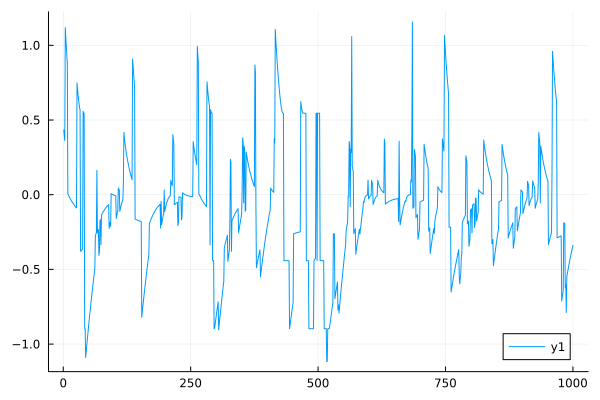

In [36]:
cp= ConsumerProblem()
test= compute_series(cp)

plot(test[3]- test[2])

In [ ]:
# Initialize main plot
plot_main = plot(size=(800, 500))  # Adjust the size of the plot

# Define gamma values
gamma_values = [1, 2, 5]

# Loop over gamma values
for γ in gamma_values
    # Solve consumer problem for different values of γ
    cp = ConsumerProblem(γ=γ)
    a_path, c_path, y_path = compute_series(cp)

    # Calculate standard deviation of the consumption path
    std_dev = round(std(c_path), digits=3)
    
    # Concatenate gamma and standard deviation to label
    label = "γ = $γ, σ = $std_dev"

    # Plot consumption path
    if γ == gamma_values[1]
        plot!(plot_main, c_path, label = label)
    else
        plot!(c_path, label = label)
    end
end

# Add labels and legend
xlabel!(plot_main, "Time")
ylabel!(plot_main, "Consumption")
title!(plot_main, "Consumption Path for Different Values of γ")


We see that the standard deviation of consumption is decreasing as the coefficient of relative risk aversion is increasing. This makes sense as we expect that the more risk averse the agent is, the more they would want to smooth consumption

C.

In [ ]:
# Initialize main plot
plot_main = plot(size=(800, 500))  # Adjust the size of the plot

# Define sigma values
innovation_variance = [0.01, 0.06, 0.12]

# Loop over sigma values
for variance in innovation_variance
    σ= sqrt(variance)
    state_values, transition_matrix= extract_rouwenhorst(ρ= 0.9, σ= σ, μ= 0)
    state_values= exp.(state_values)
    transition_matrix= transition_matrix 

    # Solve consumer problem for different values of γ
    cp = ConsumerProblem()
    a_path, c_path, y_path = compute_series(cp)

    # Calculate savings rate
    savings_path= 1 .- c_path./y_path
    
    # label string
    rounded_σ= round(σ, digits= 3)
    label_str = "\$\\sigma_{\\epsilon}^{2} = $variance\$"

    # Plot consumption path
    if σ == sigma_values[1]
        plot!(plot_main, savings_path, label = label_str)
    else
        plot!(savings_path, label = label_str)
    end
end

# Add labels and legend
xlabel!(plot_main, "Time")
ylabel!(plot_main, "Savings rate")
title!(plot_main, "Savings Path for Different Values of \$\\sigma_{\\epsilon}^{2}\$")


We see that with larger innovations in the variance of income, the savings rate is larger. Again, this makes sense. If income is more uncertain, individuals would want to save more to insure against the income risk. The precautionary motive for savings is increasing the variance of income